# PyTorch Tests On/Off

In [33]:
import numpy as np
import torch
from torch.autograd import Variable

def _log_poisson_impl(n, lam):
    normal = torch.distributions.Normal(lam,torch.sqrt(lam))
    return normal.log_prob(n)

class shapesys_constraint(object):
    def __init__(self, nom_data, mod_data):
        self.auxdata = []
        self.bkg_over_db_squared = []
        for b, deltab in zip(nom_data, mod_data):
            bkg_over_bsq = b*b/deltab/deltab # tau*b
            self.bkg_over_db_squared.append(bkg_over_bsq)
            self.auxdata.append(bkg_over_bsq)

    def alphas(self,pars):
        return np.product([pars,self.bkg_over_db_squared], axis=0)

    def logpdf(self, a, alpha):
        return _log_poisson_impl(a, alpha)

    def expected_data(self,pars):
        return self.alphas(pars)

class Model(object):
    def __init__(self, spec):
        self.samples = {}
        self.samples['sig'] = spec['sig']
        self.samples['bkg'] = spec['bkg']
        self.constraint = shapesys_constraint(spec['bkg'],spec['bkgerr'])
        
    def expected_actualdata(self, pars):
        return [pars[0]*s + pars[1]*b for s,b in zip(self.samples['sig'],self.samples['bkg'])]
        
    def expected_auxdata(self, pars):
        modparslice  = slice(1,2)
        return self.constraint.expected_data(pars[modparslice])
        
    def expected_data(self, pars, include_auxdata = True):
        expected_actual = self.expected_actualdata(pars)

        if not include_auxdata:
            return expected_actual
        expected_constraints = self.expected_auxdata(pars)
        return np.concatenate([expected_actual, expected_constraints])

        
    def logpdf(self, data, pars):
        actual_data, auxdata = [data[0]], [data[1]]
        lambdas_data = self.expected_actualdata(pars)

        sum = 0
        for d,lam in zip(actual_data, lambdas_data):
            sum = sum + _log_poisson_impl(d, lam)

        modauxslice = slice(0,1)
        thisauxdata = auxdata[slice(0,1)]

        modparslice  = slice(1,2)
        modalphas = pdf.constraint.alphas(pars[modparslice])
            
        for a,alpha in zip(thisauxdata, modalphas):
            sum = sum + self.constraint.logpdf(a, alpha)
        return sum

def loglambdav(pars,data,pdf):
    return -2*pdf.logpdf(data,pars)

def optimize(objective, init_pars, par_bounds, trf_to_unbounded = lambda x: x, trf_from_unbounded = lambda x:x, args = None, constrain_index_value = None):
    data = args[0]

    poi_index       = None
    constrained_var = None
    if constrain_index_value is not None:
        poi_index, poi_value = constrain_index_value
        
        upto   = init_pars[:poi_index]
        fromon = init_pars[poi_index+1:]
        nuis_init = np.concatenate([upto,fromon])

        init_pars = nuis_init
        constrained_var  = Variable(torch.Tensor([poi_value]), requires_grad=True)
    
    init_pars = trf_to_unbounded(init_pars)

#     print('init from: %s' % init_pars)

    parameters = Variable(torch.Tensor(init_pars), requires_grad=True)
    data       = Variable(torch.Tensor(data))
    
    optimizer = torch.optim.Adam([parameters])

    def assemble_from_nuis(nuisance_pars):
        tocat = []
        if poi_index > 0: tocat.append(nuisance_pars[:poi_index])
        tocat.append(constrained_var)
        if poi_index < len(parameters): tocat.append(nuisance_pars[poi_index:])
        return torch.cat(tocat)
    
    for i in range(1000):
        objpars = None
        if constrain_index_value is None:
            objpars = parameters
        else:
            objpars = assemble_from_nuis(parameters)
        loss = objective(objpars,data,args[1])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         if i % 1000 == 0:
#             print(trf_from_unbounded(parameters).data.numpy())
    
    result = parameters
    if constrain_index_value is not None:
        result = assemble_from_nuis(result) 
    result = trf_from_unbounded(result).data.numpy()
#     print('result %s' % result)
    return result


def unconstrained_bestfit(data,pdf, init_pars, par_bounds):
#     print 'fit', data, 'expected for init pars', np.array(pdf.expected_actualdata(init_pars))
    result = optimize(loglambdav,init_pars,par_bounds, args = (data, pdf,))
    return result

def constrained_bestfit(constrained_mu, data, pdf, init_pars, par_bounds):
#     print 'fit', data, 'for pars', np.array(pdf.expected_actualdata(init_pars))
    result = optimize(loglambdav,init_pars,par_bounds, args = (data, pdf,), constrain_index_value = (0, constrained_mu))
    return result

In [34]:
spec = {
    'obs':    [55.],
    'sig':    [10.],
    'bkg':    [50.],
    'bkgerr': [7.],    
}

pdf = Model(spec)

data       =  np.concatenate([spec['obs'] , pdf.constraint.auxdata])
init_pars  =  [1.0, 1.0] # (mu, gamma)
par_bounds = [[0,10], [0,10]]

# constrained_bestfit(1.0, data, pdf, init_pars, par_bounds)
# unconstrained_bestfit(data, pdf, init_pars, par_bounds)

In [38]:
### The Test Statistic
def generate_asimov_data(asimov_mu, data, pdf, init_pars,par_bounds):
    bestfit_nuisance_asimov = constrained_bestfit(asimov_mu,data, pdf, init_pars,par_bounds)
    return pdf.expected_data(bestfit_nuisance_asimov)

def qmu(mu,data, pdf, init_pars,par_bounds):
    mubhathat = constrained_bestfit(mu,data,pdf, init_pars,par_bounds)
    muhatbhat = unconstrained_bestfit(data,pdf, init_pars,par_bounds)
    
    v_mbhh =  Variable(torch.Tensor(mubhathat))
    v_mhbh =  Variable(torch.Tensor(muhatbhat))
    v_data =  Variable(torch.Tensor(data))
    qmu = loglambdav(v_mbhh, v_data,pdf)-loglambdav(v_mhbh, v_data,pdf)
    qmu = qmu.data.numpy()[0]
    if muhatbhat[0] > mu:
        return 0.0
    if -1e-6 < qmu <0:
        log.warning('WARNING: qmu negative: %s', qmu)
        return 0.0
    return qmu

def pvals_from_teststat(sqrtqmu_v,sqrtqmuA_v):
    from scipy.stats import norm
    CLsb = 1-norm.cdf(sqrtqmu_v )
    CLb  = norm.cdf(sqrtqmuA_v-sqrtqmu_v)
    CLs  = CLb/CLsb
    return CLsb,CLb,CLs

def runOnePoint(muTest, data,pdf, init_pars,par_bounds):
    asimov_mu = 0.0
    asimov_data = generate_asimov_data(asimov_mu,data,pdf,init_pars,par_bounds)

    qmu_v  = qmu(muTest,data,pdf, init_pars,par_bounds)
    qmuA_v = qmu(muTest,asimov_data,pdf,init_pars,par_bounds)

    sqrtqmu_v = np.sqrt(qmu_v)
    sqrtqmuA_v = np.sqrt(qmuA_v)

    sigma = muTest/sqrtqmuA_v if sqrtqmuA_v > 0 else None

    CLsb,CLb,CLs = pvals_from_teststat(sqrtqmu_v, sqrtqmuA_v)

    CLs_exp = []
    for nsigma in [-2,-1,0,1,2]:
        sqrtqmu_v_sigma =  sqrtqmuA_v-nsigma
        CLs_exp.append(pvals_from_teststat(sqrtqmu_v_sigma,sqrtqmuA_v)[-1])
    return qmu_v,qmuA_v,sigma,CLsb,CLb,CLs,CLs_exp

Populating the interactive namespace from numpy and matplotlib


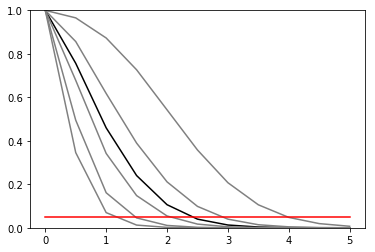

In [44]:
%pylab inline

testmus = np.linspace(0,5,11)
results = []
for mu in testmus:
    results.append(runOnePoint(mu, data, pdf, init_pars, par_bounds))

obs = [1./r[-2:][0] for r in results ]
exp = [[1./r[-2:][1][i] for r in results] for i in range(5) ]

def plot_results(testmus,cls_obs, cls_exp, test_size = 0.05):
    plt.plot(testmus,cls_obs, c = 'k')
    for i,c in zip(range(5),['grey','grey','grey','grey','grey']):
        plt.plot(testmus,cls_exp[i], c = c)
    plt.plot(testmus,[test_size]*len(testmus), c = 'r')
    plt.ylim(0,1)

    
plot_results(testmus,obs,exp)